# Workshop 10 - Training Neural Networks (Learning rate scheduling and optimisers)

Code for workshop 10.  This will use Keras (within tensorflow v2)

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

In [3]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf


## Load data
We will use MNIST, which is a set of small images (28x28) that contain 10 digits - see below for class names and an example image.

In [4]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [5]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
7


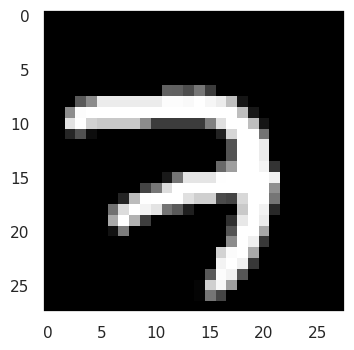

In [6]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around with the data 
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

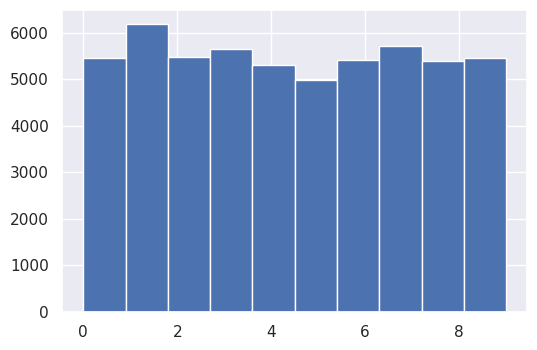

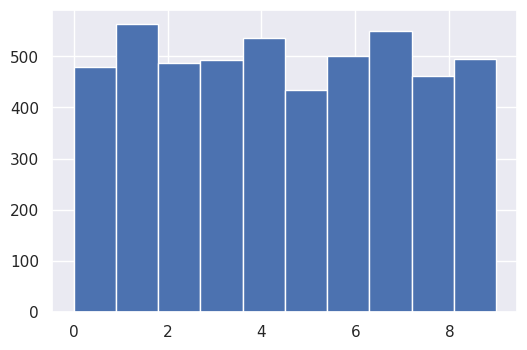

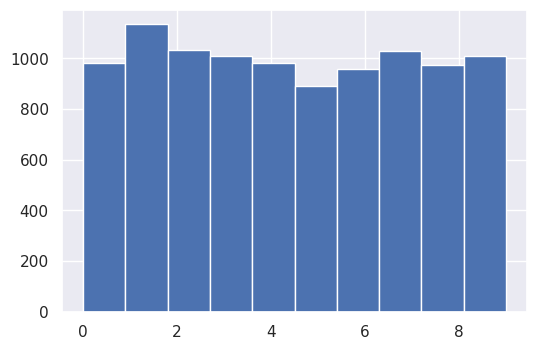

In [7]:
# Let's look at the distribution of labels in the training, validation and test sets
plt.hist(y_train)
plt.show()
plt.hist(y_valid)
plt.show()
plt.hist(y_test)
plt.show()

## Simple Neural Network Code with Keras

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [8]:
# Some key parameters
n_train = 300
n_valid = 100
# Define the number and size of hidden layers
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
#actfn = "relu"
actfn = "elu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 20

In [9]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])   
    return model

In [10]:
# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by replacing the Flatten and Dense lines with
#   model.add(keras.layers.Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate a single output per filter 
#  which requires the convolution to be "valid" and not "same"

In [11]:
def model_dense_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])
    return model

In [12]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [13]:
# Early stopping callback - this is executed when fitting and will stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True) 

In [1]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = [early_stopping_cb] + further_callbacks,
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model.evaluate(X_test, y_test, verbose=0)
    return (max_val_acc, testres[1], history, model)

In [2]:
valacc, testacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)

NameError: name 'hiddensizes' is not defined

In [1]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

In [ ]:
# We can inspect the output class predictions
y_pred = model.predict_classes(X_test[:3])  # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [ ]:
# Now run the model on the test set and get results (loss and accuracy both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

In [ ]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

# Manually exploring the learning rate



In [ ]:
# Learning rate
res=[]
for lr in [5, 4, 3, 2, 1, 0.5]:
    valacc, testacc, history, discard = do_all(hiddensizes, actfn, optimizer, lr*learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[lr*learningrate,valacc,testacc]]
print(res)

In [ ]:
# Number of layers
res=[]
for n in [1, 2, 3]:
    valacc, testacc, history, discard = do_all(hiddensizes[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[n,valacc,testacc]]
print(res)

# Exploring optimizers

Let us compare different optimizers on the same task.

In [ ]:
learning_rate=0.001
optimizer=keras.optimizers.SGD
valacc, testacc, history, discard = do_all(hiddensizes, actfn, optimizer, learning_rate, n_train, n_valid, n_epochs, batch_size)
plot_history(history)

# Your Tasks

Try out the optimizers RMSprop, Adam, Nadam, AdaMax with default settings by copying the above code and swapping out the optimizer. 

Which one has the best final classifier? 

Which one converges fastest? 

Which learning curve is the smoothest?

Which one would you choose?

# Exploring learning rate schedules

Let us compare different learning rate schedules on the same task.

In [ ]:
# Define scheduler functions
def piecewise_const(epoch):
  if epoch < 10:
    return 0.01
  else:
    return 0.001

# Run with piecewise_const learning rate scheduler
optimizer=keras.optimizers.Nadam
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_const)
valacc, testacc, history, discard = do_all(hiddensizes, actfn, optimizer, learning_rate, n_train, n_valid, n_epochs, batch_size,[lr_scheduler])
plot_history(history)

# Your Tasks: 

Write a new learning rate scheduler (copy from above and edit) that does a simple '1cycle' scheduling. Use the manual learning rate tests above BUT WITH THE NADAM OPTIMIZER! to choose a maximum learning rate. 

Manually experiment with the number of iterations for the upslope/down slope. 

Is the convergence faster than with a fixed learning rate?